In [198]:
import glob
import re
import os
from collections import Counter
import numpy as np
from tqdm import tqdm
import sentencepiece as spm
from matplotlib import pyplot as plt

In [65]:
# removing spaces from book, The Golden Bough
with open('data/golden_bough.txt','r') as f:
    corpus = f.read()
    
corpus=corpus.split('Gutenberg')[5].split('EBOOK')[1]

sents = re.sub('[^a-zA-Z\.]','',corpus.lower()).split('.')
with open('data/goldenbough.txt','w') as f:
    f.write('\n'.join(sents))

In [96]:
# displaying 20 random sentences
np.random.choice(sents,20)

array(['assomepeoplethinktheycanlightupthesunorspeedhimonhiswaysoothersfancytheycanretardorstophim',
       'thenatureofosiris',
       'iffromsicknessoranyothercausehewasunabletodischargethisdutyforthreewholedayshewashangedonthetreeinanoosewhichcontainedtworazorssoarrangedthatwhenthenoosewasdrawntightbytheweightofthekingsbodytheycuthisthroat',
       'theinterpretationofthefirefestivals',
       'whyisthisandwhyinparticularshouldamanbethoughttostunthisgrowthbyutteringhisownnamewemayconjecturethattosavageswhoactandthinkthusapersonsnameonlyseemstobeapartofhimselfwhenitisutteredwithhisownbreathutteredbythebreathofothersithasnovitalconnexionwithhimandnoharmcancometohimthroughit',
       'amongtheyorubanegroesofwestafricathehumanvictimchosenforsacrificeandwhomaybeeitherafreebornoraslaveapersonofnobleorwealthyparentageoroneofhumblebirthisafterhehasbeenchosenandmarkedoutforthepurposecalledanoluwo',
       'eatyourshareandmakeallthepeopleinthevillagewell',
       'hiswholebeingbodyandsoulisso

In [69]:
# training tokenizer
spms = f'''--input=data/goldenbough.txt 
--model_prefix=sentencepiece/goldenbough 
--vocab_size=5000'''.replace('\n','')

spm.SentencePieceTrainer.train(spms)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/goldenbough.txt --model_prefix=sentencepiece/goldenbough --vocab_size=5000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/goldenbough.txt
  input_format: 
  model_prefix: sentencepiece/goldenbough
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0

In [98]:
# saving first 500 tokens for manual review
dfgb=pd.read_csv('sentencepiece/goldenbough.vocab',sep='\t',
            header=None)

with open('goldenbough500.tsv','w') as f:
    f.write('\n'.join(dfgb[0][3:504]+'\t'))

In [124]:
# opening manually reviewed tokens
dfg = pd.read_csv('goldenbough500.tsv',
            sep='\t',header=None)

dfg.columns=['token','clas']
dfg.clas = dfg.apply(lambda D: 'b' if (len(D.token)==2 and D.clas=='x') else D.clas,axis=1)

dfg.clas.value_counts().values

array([296,  68,  58,  26,  21,  21,   8,   1])

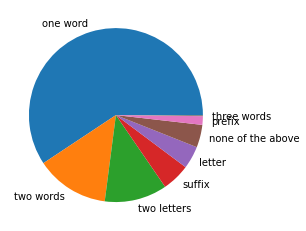

In [125]:
# manual classification of first 500 tokens
leg={'1': 'one word',
'2': 'two words',
'3': 'three words',
'l': 'letter',
's': 'suffix',
'p': 'prefix',
'x': 'none of the above',
'b':'two letters'}
C = dfg.clas.value_counts()

plt.pie(C.values,
        labels=[leg[i] for i in C.index])
plt.show()

In [127]:
# tokenization of example sentences
from matplotlib import pyplot as plt
sp = spm.SentencePieceProcessor(model_file='sentencepiece/goldenbough.model')
sent = 'thereforewhenamanoranimalisseenboldlytoappropriatethesacredfirstfruitsheoritisnaturallyregardedasthedivinityhimselfinhumanoranimalformtakingpossessionofhisown'


print(' '.join(sp.encode_as_pieces(sent)[1:]))



therefore when aman or animal is seen b old ly to appropriate thesacred firstfruit she or itis naturally regardedas the divinity himself in human or animal form taking possessionof hisown


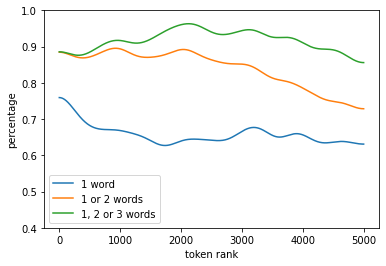

(0.658, 0.84, 0.917)

In [197]:
# determining how many tokens are words/bigrams/trigrams from book vocab
from scipy.ndimage import gaussian_filter

words = re.sub('[^a-zA-Z]',' ',corpus.lower())
words = words.split()
bigrams = [w+z for w,z in zip(words[:-1],words[1:])]
trigrams = [w+y+z for w,y,z in 
            zip(words[:-2],words[1:-1],words[2:])]

words = set(words)
bigrams = words|set(bigrams)
trigrams = bigrams|set(trigrams)

toks = dfgb[0][3:].tolist()
in1s = [float(t.replace('▁','') in words) for t in toks]
in2s = [float(t.replace('▁','') in bigrams) for t in toks]
in3s = [float(t.replace('▁','') in trigrams) for t in toks]

plt.plot(gaussian_filter(in1s,sigma=200),label='1 word')
plt.plot(gaussian_filter(in2s,sigma=200),label='1 or 2 words')
plt.plot(gaussian_filter(in3s,sigma=200),label='1, 2 or 3 words')
plt.ylim(.4,1)
plt.xlabel('token rank')
plt.ylabel('percentage')
plt.legend()
plt.show()
np.round(np.mean(in1s),3),\
np.round(np.mean(in2s),3),\
np.round(np.mean(in3s),3)

In [194]:
# first 20 tokens in bigrams
[t for t in toks 
 if t.replace('▁','') not in words
 and t.replace('▁','') in bigrams][:20]



['ofthe',
 'inthe',
 'tothe',
 'onthe',
 'itis',
 'tobe',
 'fromthe',
 'ina',
 'andthe',
 'bythe',
 'im',
 'asa',
 'withthe',
 'forthe',
 'thatthe',
 'ofa',
 'thesame',
 'itwas',
 'atthe',
 'allthe']

In [186]:
# tokens not in trigrams
[t for t in toks if t.replace('▁','') not in trigrams]

['▁',
 'ed',
 'ing',
 'ly',
 'sof',
 'al',
 'es',
 'edby',
 'ic',
 'ro',
 'con',
 'ion',
 'ation',
 'sare',
 'il',
 'ers',
 'dis',
 'softhe',
 'ul',
 'ir',
 'ri',
 'sto',
 'ap',
 'um',
 'te',
 'ity',
 'edwith',
 'ingthe',
 'ated',
 'mo',
 'ful',
 'swere',
 'ies',
 'ol',
 'ti',
 'ian',
 'ment',
 'cr',
 'ted',
 'ent',
 'ty',
 'ous',
 'swhich',
 'ce',
 'ag',
 'che',
 'em',
 'ex',
 'sh',
 'dby',
 'ter',
 'ga',
 'ious',
 'ling',
 'edand',
 'sp',
 'wa',
 'com',
 'ard',
 'par',
 'gu',
 'ting',
 'ence',
 'ver',
 'op',
 'ness',
 'ble',
 'ish',
 'ut',
 'fer',
 'ationof',
 'fo',
 'ig',
 'mis',
 'pl',
 'ang',
 'qui',
 'ju',
 'bu',
 'dic',
 'ug',
 'ionof',
 'sup',
 'ance',
 'ru',
 'bla',
 'mu',
 'mer',
 'ell',
 'les',
 'mi',
 'har',
 'pur',
 'trans',
 'ip',
 'cy',
 'eus',
 'cur',
 'hi',
 'pri',
 'ick',
 'ob',
 'lim',
 'ber',
 'que',
 'sur',
 'ke',
 'ung',
 'attheendof',
 'ical',
 'ff',
 'bi',
 'clu',
 'ned',
 'min',
 'hu',
 'bur',
 'oc',
 'uc',
 'stra',
 'ven',
 'jo',
 'fe',
 'exp',
 'sfrom',
 'ect